In [ ]:
import random
import torch
import torch.nn as nn
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
root_dir = '/content/drive/MyDrive/Project 2 - 20242/weather-dataset/dataset'
img_paths = []
labels = []
classes = {
  label_idx: class_name \
    for label_idx, class_name in enumerate(
     sorted(os.listdir(root_dir))
 )
}

In [ ]:
img_paths = []
labels = []
for label_idx, class_name in classes.items():
  class_dir = os.path.join(root_dir, class_name)
  for img_filename in os.listdir(class_dir):
    img_path = os.path.join(class_dir, img_filename)
    img_paths.append(img_path)
    labels.append(label_idx)

In [ ]:
seed = 0
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size = val_size,
    random_state = seed,
    shuffle = is_shuffle)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size = test_size,
    random_state = seed,
    shuffle = is_shuffle)

In [ ]:
class Weather_Dataset(Dataset):
  def __init__(
      self,
      X, y,
      transform=None):
    self.transform = transform
    self.img_paths = X
    self.labels = y

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, idx):
    img_path = self.img_paths[idx]
    img = Image.open(img_path).convert('RGB')
    label = self.labels[idx]

    if self.transform:
      img = self.transform(img)
    return img, self.labels[idx]

In [ ]:
def transform(img, img_size=(224, 224)):
    img = img.resize(img_size)
    img = np.array(img)[..., :3]
    img = torch.tensor(img).permute(2, 0, 1).float() / 255.0
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = (img - mean) / std
    return img

In [ ]:
train_dataset = Weather_Dataset(X_train, y_train, transform=transform)
val_dataset = Weather_Dataset(X_val, y_val, transform=transform)
test_dataset = Weather_Dataset(X_test, y_test, transform=transform)

In [ ]:
train_batch_size = 512
test_batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride = 1):
    super(ResidualBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                           stride=stride, padding=1)
    self.batch_norm1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                           stride=1, padding=1)
    self.batch_norm2 = nn.BatchNorm2d(out_channels)
    self.downsample = nn.Sequential()
    if stride != 1 or in_channels != out_channels:
      self.downsample = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size=1,
                    stride=stride),
          nn.BatchNorm2d(out_channels)
      )
    self.relu=nn.ReLU()
  def forward(self, x):
    shortcut = x.clone()
    x = self.conv1(x)
    x = self.batch_norm1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.batch_norm2(x)
    x+= self.downsample(shortcut)
    x = self.relu(x)
    return x

In [ ]:
class ResNet(nn.Module):
  def __init__(self, residual_block, n_block_lst, n_classes):
    super(ResNet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64,
                           kernel_size=7, stride=2, padding=3)
    self.batch_norm1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()
    self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.conv2 = self.create_layer(residual_block, 64, 64, n_block_lst[0], 1)
    self.conv3 = self.create_layer(residual_block, 64, 128, n_block_lst[1], 2)
    self.conv4 = self.create_layer(residual_block, 128, 256, n_block_lst[2], 2)
    self.conv5 = self.create_layer(residual_block, 256, 512, n_block_lst[3], 2)
    self.avg_pool = nn.AdaptiveAvgPool2d(1)
    self.flatten = nn.Flatten()
    self.fc = nn.Linear(512, n_classes)
  def create_layer(self, residual_block, in_channels, out_channels, n_blocks, stride):
    blocks = []
    frist_block = residual_block(in_channels, out_channels, stride)
    blocks.append(frist_block)

    for idx in range(1, n_blocks):
      block = residual_block(out_channels, out_channels, stride=1)
      blocks.append(block)
    block_sequential = nn.Sequential(*blocks)
    return block_sequential
  def forward(self, x):
    x = self.conv1(x)
    x = self.batch_norm1(x)
    x = self.max_pool(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = self.avg_pool(x)
    x = self.flatten(x)
    x = self.fc(x)
    return x

In [ ]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ResNet(ResidualBlock, n_block_lst = [2, 2, 2, 2], n_classes = n_classes).to(device)

In [ ]:
def evaluate(model, dataloader, criterion, device, report=False):
  model.eval()
  correct = 0
  total = 0
  losses = []
  all_preds = []
  all_labels = []
  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      losses.append(loss.item())
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      if report:
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
  loss = sum(losses) / len(losses)
  acc = correct / total

  return loss, acc

In [ ]:
def fit(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs):
  train_losses = []
  val_losses = []

  for epoch in range(epochs):
    batch_train_losses = []
    model.train()
    for idx, (inputs, labels) in enumerate(train_loader):
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      batch_train_losses.append(loss.item())

    train_loss = sum(batch_train_losses) / len(batch_train_losses)
    train_losses.append(train_loss)

    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)

    scheduler.step()

    print(f'Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%')

  return train_losses, val_losses

In [ ]:
lr = 1e-3
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [ ]:
train_losses, val_losses = fit(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs)

Epoch: 1/50, Train Loss: 2.3608, Val Loss: 2.3686, Val Acc: 17.26%
Epoch: 2/50, Train Loss: 2.1491, Val Loss: 2.3379, Val Acc: 14.42%
Epoch: 3/50, Train Loss: 2.0054, Val Loss: 2.2015, Val Acc: 24.47%
Epoch: 4/50, Train Loss: 1.9025, Val Loss: 1.9859, Val Acc: 37.14%
Epoch: 5/50, Train Loss: 1.8105, Val Loss: 1.8274, Val Acc: 41.15%
Epoch: 6/50, Train Loss: 1.7327, Val Loss: 1.7230, Val Acc: 43.63%
Epoch: 7/50, Train Loss: 1.6593, Val Loss: 1.6558, Val Acc: 44.87%
Epoch: 8/50, Train Loss: 1.6111, Val Loss: 1.5950, Val Acc: 46.69%
Epoch: 9/50, Train Loss: 1.5616, Val Loss: 1.5642, Val Acc: 47.41%
Epoch: 10/50, Train Loss: 1.5262, Val Loss: 1.5221, Val Acc: 48.51%
Epoch: 11/50, Train Loss: 1.4998, Val Loss: 1.4900, Val Acc: 49.31%
Epoch: 12/50, Train Loss: 1.4547, Val Loss: 1.4574, Val Acc: 49.89%
Epoch: 13/50, Train Loss: 1.4241, Val Loss: 1.4368, Val Acc: 51.27%
Epoch: 14/50, Train Loss: 1.4037, Val Loss: 1.4164, Val Acc: 53.24%
Epoch: 15/50, Train Loss: 1.3802, Val Loss: 1.3858, Val A

In [ ]:
model_path = 'resnet18_weather.pth'
torch.save(model.state_dict(), model_path)
print(f"✅ Mô hình đã được lưu vào file '{model_path}'")

✅ Mô hình đã được lưu vào file 'resnet18_weather.pth'


In [ ]:
val_losses, val_acc = evaluate(model, val_loader, criterion, device)
test_losses, test_acc = evaluate(model, test_loader, criterion, device)
print(f'Val Loss: {val_losses:.4f}, Val Acc: {val_acc*100:.2f}%')
print(f'Test Loss: {test_losses:.4f}, Test Acc: {test_acc*100:.2f}%')

Val Loss: 1.1685, Val Acc: 62.42%
Test Loss: 1.2033, Test Acc: 60.55%


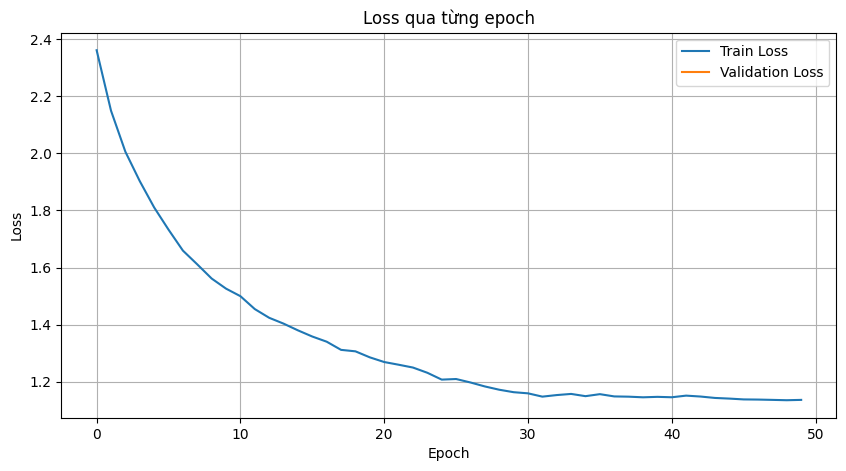

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss qua từng epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def visualize_predictions(model, dataset, class_names, device, num_images=50):
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)
    cols = 10
    rows = num_images // cols + int(num_images % cols != 0)

    plt.figure(figsize=(cols * 2, rows * 2.5))

    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        input_tensor = img.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            pred = torch.argmax(output, dim=1).item()

        img_np = img.permute(1, 2, 0).cpu().numpy()
        img_np = np.clip(img_np * 255.0, 0, 255).astype(np.uint8)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img_np)
        plt.axis('off')
        plt.title(f'Thực tế: {class_names[label]}\nDự đoán: {class_names[pred]}', fontsize=8)

    plt.tight_layout()
    plt.show()

In [ ]:
visualize_predictions(model, test_dataset, class_names, device, num_images=50)

Output hidden; open in https://colab.research.google.com to view.